In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

f"{np.__version__=}"

"np.__version__='1.26.4'"

In [2]:
from laser_core.propertyset import PropertySet

from laser_generic import Model

In [3]:
scenario = pd.DataFrame(data=[["homenode", 1e6, "47°36′35″N 122°19′59″W"]], columns=["name", "population", "location"])
parameters = PropertySet({"seed": 2, "nticks": 730, "verbose": True, "beta": 0.1})
model = Model(scenario, parameters)

2024-12-10 19:40:16.206906: Creating the generic model…
Initializing the generic model with 1 patches…


In [4]:
from laser_generic.susceptibility import Susceptibility
from laser_generic.transmission import Transmission

model.components = [
    Transmission,
    Susceptibility,
]

In [5]:
from laser_generic.utils import seed_infections_randomly_SI

seed_infections_randomly_SI(model, ninfections=1)

In [6]:
model.run()

2024-12-10 19:40:20.414799: Running the generic model for 730 ticks…


100%|██████████| 730/730 [00:02<00:00, 275.43it/s]

Completed the generic model at 2024-12-10 19:40:23.070370…
Model         :         3,149 µs
Transmission  :     2,121,492 µs
Susceptibility:       492,903 µs
Total:              2,617,544 microseconds


In [7]:
# Testing a feature intended to provide fast transmission via sampling, but actually performs worse than the numba loop.
parameters = PropertySet({"seed": 2, "nticks": 730, "verbose": True, "beta": 0.1, "fast_transmission": True})
model = Model(scenario, parameters)
model.components = [
    Susceptibility,
    Transmission,
]
seed_infections_randomly_SI(model, ninfections=1)
model.run()

2024-12-05 04:49:44.214625: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-05 04:49:44.221192: Running the generic model for 730 ticks…


100%|██████████| 730/730 [00:13<00:00, 52.54it/s] 

Completed the generic model at 2024-12-05 04:49:58.118316…
Model       :         8,547 µs
Transmission:    13,553,556 µs
Total:           13,562,103 microseconds


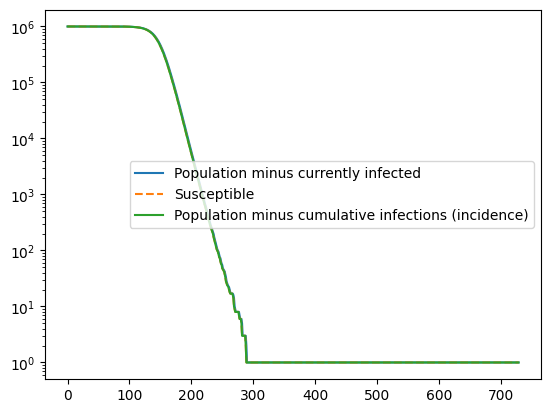

In [7]:
plt.plot(1e6 - model.patches.cases.astype("int") + 1)
plt.plot(model.patches.susceptibility.astype("int") + 1, "--")
plt.plot(1e6 - np.cumsum(model.patches.incidence).astype("int"))
plt.yscale("log")
plt.legend(["Population minus currently infected", "Susceptible", "Population minus cumulative infections (incidence)"])

In [22]:
np.cumsum(model.patches.incidence).astype("int")[-1]

993760

(0.0, 250.0)

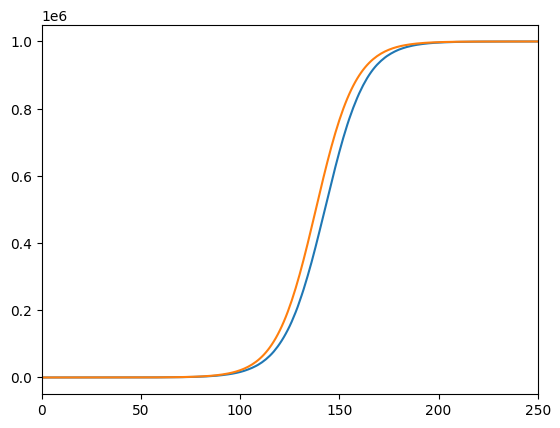

In [8]:
import matplotlib.pyplot as plt

plt.plot(model.patches.cases)
plt.plot(1e6 / (1 + (1e6 - 1) * np.exp(-0.1 * (np.arange(730)))))
plt.xlim([0, 250])
# plt.ylim([100, 150])

2024-12-05 04:59:08.141254: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-05 04:59:08.146340: Running the generic model for 730 ticks…


100%|██████████| 730/730 [00:00<00:00, 941.77it/s] 

Completed the generic model at 2024-12-05 04:59:08.924181…
Model       :         2,447 µs
Transmission:       761,693 µs
Total:              764,140 microseconds
2024-12-05 04:59:08.932078: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-05 04:59:08.934387: Running the generic model for 730 ticks…



/tmp/ipykernel_2561/1337495924.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output = pd.concat([output, pd.DataFrame.from_dict({"seed": seed, "beta": beta, "cases": [np.array(cases)],
100%|██████████| 730/730 [00:00<00:00, 1073.95it/s]

Completed the generic model at 2024-12-05 04:59:09.617848…
Model       :         2,238 µs
Transmission:       669,070 µs
Total:              671,308 microseconds
2024-12-05 04:59:09.623485: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-05 04:59:09.625308: Running the generic model for 730 ticks…



100%|██████████| 730/730 [00:00<00:00, 1158.00it/s]

Completed the generic model at 2024-12-05 04:59:10.258471…
Model       :         2,402 µs
Transmission:       620,338 µs
Total:              622,740 microseconds
2024-12-05 04:59:10.263950: Creating the generic model…
Initializing the generic model with 1 patches…


2024-12-05 04:59:10.265662: Running the generic model for 730 ticks…


100%|██████████| 730/730 [00:00<00:00, 1897.27it/s]

Completed the generic model at 2024-12-05 04:59:10.654218…
Model       :         2,137 µs
Transmission:       374,889 µs
Total:              377,026 microseconds
2024-12-05 04:59:10.658484: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-05 04:59:10.660590: Running the generic model for 730 ticks…



100%|██████████| 730/730 [00:00<00:00, 1786.56it/s]

Completed the generic model at 2024-12-05 04:59:11.073172…
Model       :         3,557 µs
Transmission:       396,045 µs
Total:              399,602 microseconds
2024-12-05 04:59:11.077510: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-05 04:59:11.080060: Running the generic model for 730 ticks…



100%|██████████| 730/730 [00:00<00:00, 2468.27it/s]


Completed the generic model at 2024-12-05 04:59:11.379946…
Model       :         2,958 µs
Transmission:       286,692 µs
Total:              289,650 microseconds
2024-12-05 04:59:11.385031: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-05 04:59:11.387061: Running the generic model for 730 ticks…


100%|██████████| 730/730 [00:00<00:00, 1198.04it/s]

Completed the generic model at 2024-12-05 04:59:11.999428…
Model       :         3,530 µs
Transmission:       587,090 µs
Total:              590,620 microseconds
2024-12-05 04:59:12.004259: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-05 04:59:12.005975: Running the generic model for 730 ticks…



100%|██████████| 730/730 [00:00<00:00, 2955.93it/s]

Completed the generic model at 2024-12-05 04:59:12.255806…
Model       :         1,935 µs
Transmission:       240,168 µs
Total:              242,103 microseconds
2024-12-05 04:59:12.260852: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-05 04:59:12.262599: Running the generic model for 730 ticks…



100%|██████████| 730/730 [00:00<00:00, 2992.54it/s]

Completed the generic model at 2024-12-05 04:59:12.509382…
Model       :         1,954 µs
Transmission:       237,087 µs
Total:              239,041 microseconds
2024-12-05 04:59:12.514602: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-05 04:59:12.516603: Running the generic model for 730 ticks…



100%|██████████| 730/730 [00:00<00:00, 2477.43it/s]


Completed the generic model at 2024-12-05 04:59:12.814865…
Model       :         1,970 µs
Transmission:       284,319 µs
Total:              286,289 microseconds


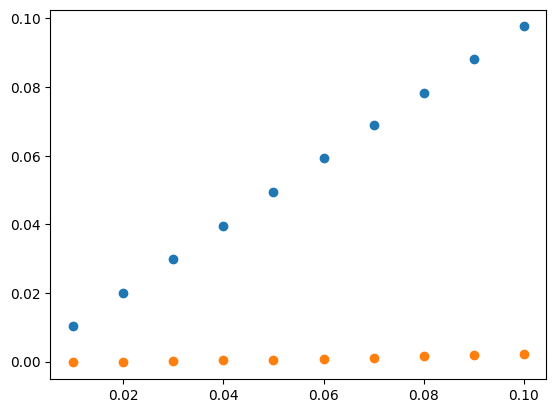

In [26]:
def SI_logistic(t, beta, size, t0):
    return size / (1 + (size - 1) * np.exp(-beta * (t - t0)))


nticks = 730
t = np.arange(730)

seeds = [i for i in range(10)]
betas = [0.01 * i for i in range(1, 11)]
output = pd.DataFrame(columns=["seed", "beta", "cases", "fitted_beta", "fitted_size", "fitted_t0"])
scenario = pd.DataFrame(data=[["homenode", 1e5, "47°36′35″N 122°19′59″W"]], columns=["name", "population", "location"])
for seed, beta in zip(seeds, betas):
    parameters = PropertySet({"seed": seed, "nticks": nticks, "verbose": True, "beta": beta})
    model = Model(scenario, parameters)
    model.components = [
        Susceptibility,
        Transmission,
    ]
    seed_infections_randomly_SI(model, ninfections=1)
    model.run()
    cases = [model.patches.cases[i][0] for i in range(nticks)]
    popt, pcov = curve_fit(SI_logistic, t, cases, p0=[0.05, 1.1e5, 1])

    output = pd.concat(
        [
            output,
            pd.DataFrame.from_dict(
                {
                    "seed": seed,
                    "beta": beta,
                    "cases": [np.array(cases)],
                    "fitted_beta": popt[0],
                    "fitted_size": popt[1],
                    "fitted_t0": popt[2],
                }
            ),
        ],
        ignore_index=True,
    )


plt.plot(output["beta"], output["fitted_beta"], "o")
plt.plot(output["beta"], output["beta"] - output["fitted_beta"], "o")

In [27]:
output

,seed,beta,cases,fitted_beta,fitted_size,fitted_t0
0,0,0.01,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.010248,86271.593842,40.983277
1,1,0.02,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.020005,98502.202153,170.607335
2,2,0.03,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.029792,100013.726252,83.536487
3,3,0.04,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.039473,100014.746528,25.712536
4,4,0.05,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.049396,100015.932826,18.848006
5,5,0.06,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.059324,100015.870044,7.180719
6,6,0.07,"[1, 1, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, ...",0.068990,100003.503154,-4.206395
7,7,0.08,"[1, 1, 3, 3, 3, 3, 4, 6, 8, 8, 9, 9, 11, 11, 1...",0.078403,100007.702067,-15.295213
8,8,0.09,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, ...",0.088176,100007.721573,5.361267
9,9,0.10,"[1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, ...",0.097672,100007.334265,8.820256


In [24]:
output

In [25]:
pd.DataFrame.from_dict({"a": 1, "b": 2, "c": [np.array([1, 2, 3])]})

,a,b,c
0,1,2,"[1, 2, 3]"
